## Predicting NC's Existing Seasons
### Supervised Learning with Assorted Classifiers

In this notebook, I go through the test, train, and validation stages of building a classifier model. I use 10-fold cross validation to test random forest, decision tree, and k-nearest neighbors classifiers, and I find that a decision tree classifier is the best model for predicting the season of a day of weather in NC based on weather characteristics such as temperature, pressure, and precipitation. Then, I build this decision tree classifier and validate the model on the remaining 10% of the data, which I had previously withheld from testing and training, achieving a validation error of 12.4%. Considering that North Carolina's weather doesn't feel like it fits the official seasons, this seems to be a reasonably accurate model.

This notebook is a complement to the clustering project, where I throw away the traditional seasonal boundaries and cluster NC's weather into a new set of seasons.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ML tools
import itertools
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# helper functions

# adapted from original code in lab 6
def standardize(data):
    '''Standardize a dataframe'''
    mean_vec = np.mean(data, axis=0)
    sd_vec = np.std(data, axis=0)

    data_std = data.copy()
    for i in range(data.shape[1]): # for every column
        data_std[:,i] = (data[:,i] - mean_vec[i]*np.ones(data.shape[0]))/sd_vec[i]
        
    return data_std

# adapted from original code in project 2
def divide_data(rent):
    '''divide dataset into two sets: 90% test/train and 10% validation'''
    n = rent.shape[0]
    
    # take out 10% of the data for validation
    # https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
    ind_valid = np.random.choice(n, size = n // 10, replace = False)
    rent_valid = rent.iloc[ind_valid]

    # take the other 90% for building the model
    # https://stackoverflow.com/questions/27824075/accessing-numpy-array-elements-not-in-a-given-index-list
    ind_tt = [x for x in range(n) if x not in ind_valid] # not in index
    rent_tt = rent.iloc[ind_tt]

    # shuffle data for test/train so no patterns in folds
    # https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
    rent_tt = shuffle(rent_tt)

    return rent_valid, rent_tt

def classification_mse(class_truth, pred_class):
    '''compute classification mse'''
    return np.mean(class_truth != pred_class)

def cross_validation(data, method, k):    
    '''k-fold cross-validation'''
    # calculate fold divisions
    n = data.shape[0]
    n_predictors = data.shape[1] - 1
    foldSize =  n // k # int divide
    foldDivisions = [foldSize * x for x in range(k+1)]

    # adjust for uneven fold size
    if n % k != 0: 
        r = n % k # remainder
        for i in range(1, k+1):
            # add 1 + previous size increase to each group until r
            # then just shift by r to account for previous size increases
            foldDivisions[i] += min(i, r)

    # divide into folds
    folds = []
    for i in range(k):
        folds.append(data.iloc[foldDivisions[i]:foldDivisions[i+1], :])

    # linear model w/ each fold as test once
    test_errors = []

    for i in range(k):
        # get test fold
        test = folds[i]

        # combine other folds into training set
        train_folds = folds.copy()
        train_folds.pop(i)
        # https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
        train = pd.concat(train_folds) # concatenate folds

        if method == 'SVM':
            # fit SVM to training data
            mod = SVC(kernel="rbf")
        elif method == 'neighbor':
            # fit kNN to training data
            mod = KNeighborsClassifier(n_neighbors = 9)
        elif method == 'tree':
            # fit decision tree to training data
            mod = DecisionTreeClassifier()
        elif method == 'forest':
            # build random forest classifier for training data
            mod = RandomForestClassifier(n_estimators=10, max_features = min(3, n_predictors), max_depth=3, random_state=0)
        
        mod.fit(train.iloc[:,:-1], train.iloc[:,-1]) # class var in last column
        
        # compute testing error
        test_preds = mod.predict(test.iloc[:,:-1])
        test_error = classification_mse(test_preds, test.iloc[:,-1])
        test_errors.append(test_error)

    # cross validation error - avg of test errors
    cross_val_error = np.mean(test_errors)
    
    return cross_val_error

def all_cv_errors(rent_tt, methods):
    '''get cross-validation error for all possible models'''
    cv_errors = []     
    # test each possible model type
    for method in methods:
        # compute cross-validation error
        cv_err = cross_validation(rent_tt, method, 10)

        # store errors
        cv_errors.append([method, cv_err])
                
    # sort cv errors w/ lowest in first row
    cv_err_np = np.array(cv_errors, dtype=object)
    cv_err_np = cv_err_np[np.argsort(cv_err_np[:,1])]
    return cv_err_np

## Import Data
We are once again exploring weather data for the RDU airport in NC's Research Triangle region since  2000, as explored in `data/Data-Wrangling.ipynb` and `data/Data-Visualization.ipynb`. When we import our data, we drop variables that are missing for large portions of the data (`STP` and `GUST`) or likely irrelevant to the data (`YEAR` and `DAY`).

In [3]:
# import data
weather_pd = pd.read_csv('../data/weather.csv', index_col = 0)
weather_pd = weather_pd.drop(['YEAR', 'DAY', 'STP', 'GUST'], axis=1) # remove faulty columns and some temporal indicators

weather_pd.shape

(7772, 12)

In [4]:
# move seasons (classes) to last column
columns = list(weather_pd.columns)
columns.remove('SEASON')
columns.append('SEASON')
weather_pd = weather_pd[columns]

weather_pd.shape

(7772, 12)

In [5]:
# peek at data
weather_pd.head()

,MONTH,TEMP,DEWP,SLP,VISIB,WDSP,MXSPD,MAX,MIN,PRCP,SNDP,SEASON
0,1,47.6,38.1,1023.7,8.3,3.0,10.1,66.9,33.1,0.00,0.0,0
1,1,55.3,46.3,1024.2,9.5,4.8,14.0,70.0,33.1,0.00,0.0,0
2,1,62.6,55.4,1021.3,8.4,8.5,14.0,73.9,43.0,0.00,0.0,0
3,1,65.2,58.6,1014.4,9.5,15.3,28.0,73.9,55.0,0.00,0.0,0
4,1,45.7,30.9,1019.8,9.8,6.4,11.1,57.9,37.0,0.34,0.0,0


## Glimpse the Data in 2D
Our weather data contains 12 variables including information on temperatures, pressure, visibility, wind speed, precipitation, and more. We can summarize this data in 2D to get a sense of the general shape of the data. Below, we label our data by season and observe four fairly distinct regions of weather, but no clear separation between seasons. This lack of clear boundaries is to be expected, since seasons don't change overnight—some days will fall in the transition between seasons. However, these regions of overlap will be a challenge to our classifier model.

In [9]:
# summarize in 2D
pca = PCA(n_components=2)
weather_two = pca.fit_transform(standardize(weather_pd.to_numpy()))

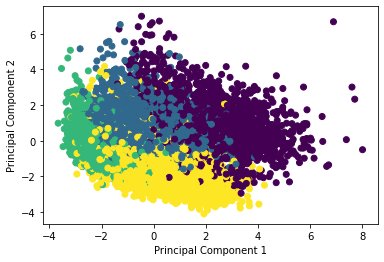

In [10]:
# plot 2D weather with colors by season
# winter = purple, spring = blue, summer = green, fall = yellow
plt.scatter(weather_two[:,0], weather_two[:,1], c=weather_pd['SEASON'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2');

## Divide into Test/Train and Validation Sets

First, we divide the data into a test/train set and a validation set. We will build our model from the test/train set (90% of the data), then validate the accuracy of our model on weather that is entirely new to it by asking the model to classify the validation set (10% of the data). 

In [11]:
# separate data into test/train and validation sets
np.random.seed(888)
weather_valid, weather_tt = divide_data(weather_pd)

## Cross-Validation for Model Selection

Next, we use 10-fold cross validation on our test/train dataset to find the best model to fit the data. For each type of classifier (k-nearest neighbor, decision tree, and random forest), we build a model 10 times, training on a different 90% of the data each time and testing on the other 10%. Then, we average out the errors of those 10 tests to get the average testing error of each type of model (the cross-validation error).

In [13]:
# get all cv errors for all combos of predictor features
# for each method
cv_errors = all_cv_errors(weather_tt, ['neighbor', 'tree', 'forest']) # excluding 'SVM'

# store best combo of features
best_method = cv_errors[0,0]
lowest_cv_err = cv_errors[0,1]

In [14]:
# print best model
print('best model')
print('method:  ', best_method)
print('error:   ', lowest_cv_err)

best model
method:   tree
error:    0.1369558553034948


Since the decision tree classifier resulted in the lowest cross-validation error, we decide that this is the best model for our data.

I built the `all_cv_errors()` function to perform cross validation for four types of classifier models, including a support vector machine (SVM) with a radial basis kernel. However, a SVM classifier did not seem appropriate for this particular dataset due to the lack of clear boundaries between seasons, even in higher dimensions, so I excluded SVM from this particular analysis. (I left the functionality for potential future use.)

## Build the Model

Now that we have decided to use a decision tree classifier as our model, we build the model from the entire test/train dataset.

In [15]:
# build model from best features 
dt = DecisionTreeClassifier()
dt.fit(weather_tt.iloc[:,:-1], weather_tt.iloc[:,-1]) # from all but the last column, predict last column

DecisionTreeClassifier()

## Validate the Model

To test the effectiveness of our model, we validate the model by asking it to predict the season for the new  days in the validation set. The model has never seen this 10% of the data before, but we hope that the model will perform as well on the new data (validation error) as it did during our model selection (cross-validation error).

In [11]:
# compute validation error
val_preds = dt.predict(weather_valid.iloc[:,:-1])
val_error = classification_mse(val_preds, weather_valid.iloc[:,-1])

In [12]:
print('validation error:           ', val_error)
print('best cross-validation error:', lowest_cv_err)

validation error:            0.12355212355212356
best cross-validation error: 0.13524054772123442


Since our validation error is similar to our cross-validation error, this model performs reasonably well on new data.

## Conclusion

When we predicted seasons for our validation set, our decision tree model was only wrong 12.4% of the time—meaning it classified seasons correctly for 87.6% of our data, or about 10 1/2 months a year. While I wouldn't trust a 87.6% accuracy in more important decision-making scenarios, this is a very reasonable accuracy for our toy project of predicting the season of a day of weather. We would rarely see weather data without an associated day, so predicting the season of a day may not be so useful in practice; however, it's exciting to find that we can predict seasons reasonably accurately despite how North Carolina doesn't feel like it aligns with traditional seasonal boundaries. Perhaps, after all, North Carolina's seasons are more distinct than they seem.

In future work, I would be curious to build a classifier based on the alternative 5-season model I built in the clustering project. It would be interesting to see if this classifier would be more accurate, since it is tailored to this dataset, or less accurate, since seasons are not as consecutive.